In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import os
import json
import warnings
warnings.filterwarnings("ignore")

2025-08-27 19:17:39.222299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756322259.459528      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756322259.522413      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Data loading code
def create_df(path):
    dd = {"images": [], "labels": []}

    for i in os.listdir(path):
        img_dir = os.path.join(path, i)
        
        # Skip if not a directory (this fixes your error)
        if not os.path.isdir(img_dir):
            print(f"Skipping non-directory: {i}")
            continue
        
        # Get subdirectories only
        subdirs = [d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))]
        if len(subdirs) == 0:
            print(f"No subdirectories found in: {i}")
            continue
            
        addition = subdirs[0]
        img_dir_full = os.path.join(img_dir, addition)
        
        index = 0
        for j in os.listdir(img_dir_full):
            if j.endswith(".png"):
                dd["images"].append(os.path.join(img_dir_full, j))
                dd["labels"].append(i)
                index += 1
                if index >= 400:
                    break

    return pd.DataFrame(dd)

# Configuration
class Config:
    EPOCHS = 50
    IMG_SIZE = 224
    BATCH_SIZE = 16
    LR = 0.001
    VALIDATION_SPLIT = 0.2
    TEST_SPLIT = 0.1
    SEED = 229
    
    # Model specific settings
    PATIENCE = 10
    FACTOR = 0.5
    MIN_LR = 1e-7

In [3]:
# Data preprocessing functions
def preprocess_image(image_path, img_size=Config.IMG_SIZE):
    """Load and preprocess a single image"""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [img_size, img_size])
    image = tf.cast(image, tf.float32) / 255.0
    return image

def create_dataset(df, batch_size=Config.BATCH_SIZE, shuffle=True, augment=False):
    """Create TensorFlow dataset from DataFrame"""
    
    def load_and_preprocess_image(path, label):
        return preprocess_image(path), label
    
    # Create dataset from paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((df['images'].values, df['labels'].values))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=Config.SEED)
    
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [4]:
def augment_image(image, label):
    """Data augmentation function"""
    # image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_brightness(image, 0.1)
    # image = tf.image.random_contrast(image, 0.9, 1.1)
    # image = tf.image.random_saturation(image, 0.9, 1.1)
    # image = tf.image.random_hue(image, 0.05)
    # # Random rotation
    # image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    return image, label

In [5]:
# Model creation function
def create_transfer_model(base_model_func, num_classes, input_shape=(224, 224, 3), 
                         trainable_layers=0, dropout_rate=0.5):
    """
    Create a transfer learning model
    
    Args:
        base_model_func: Function to create base model (e.g., ResNet50, VGG16)
        num_classes: Number of output classes
        input_shape: Input image shape
        trainable_layers: Number of top layers to make trainable (0 = freeze all)
        dropout_rate: Dropout rate for regularization
    """
    
    # Create base model
    base_model = base_model_func(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Unfreeze top layers if specified
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True
    
    # Create full model
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax', name='classification_head')
    ])
    
    return model

In [6]:
# Training function
def train_model(model, train_dataset, val_dataset, model_name, epochs=Config.EPOCHS, save_json=True):
    """Train a model with callbacks and return history"""
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=Config.LR),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=Config.PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=Config.FACTOR,
            patience=Config.PATIENCE//2,
            min_lr=Config.MIN_LR,
            verbose=1
        ),
        ModelCheckpoint(
            f'best_{model_name}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

In [7]:
def save_metrics_to_json(history, evaluation_metrics, model_name, filename=None):
    """
    Save training history and evaluation metrics to a JSON file.
    
    Args:
        history: keras.callbacks.History object from model training
        evaluation_metrics: dict containing evaluation data
        model_name: name of the model
        filename: optional custom filename, otherwise auto-generated
    """
    if filename is None:
        filename = f"{model_name}_metrics.json"
    
    # Convert numpy arrays to lists for JSON serialization
    def convert_to_serializable(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.float32) or isinstance(obj, np.float64):
            return float(obj)
        elif isinstance(obj, np.int32) or isinstance(obj, np.int64):
            return int(obj)
        return obj
    
    # Prepare data to save
    metrics_data = {
        "model_name": model_name,
        "training_history": {
            key: [convert_to_serializable(val) for val in values] 
            for key, values in history.history.items()
        },
        "evaluation_metrics": {
            key: convert_to_serializable(value) 
            for key, value in evaluation_metrics.items()
        },
        "training_info": {
            "total_epochs": len(history.history['loss']),
            "best_val_accuracy": convert_to_serializable(max(history.history.get('val_accuracy', [0]))),
            "best_val_loss": convert_to_serializable(min(history.history.get('val_loss', [float('inf')]))),
            "final_train_accuracy": convert_to_serializable(history.history['accuracy'][-1]),
            "final_train_loss": convert_to_serializable(history.history['loss'][-1])
        }
    }
    
    # Save to JSON file
    with open(filename, 'w') as f:
        json.dump(metrics_data, f, indent=4)
    
    print(f"Metrics saved to {filename}")
    return filename

In [8]:
# Evaluation functions
def evaluate_model(model, test_dataset, test_labels, class_names, model_name, save_json=True):
    """Comprehensive model evaluation with JSON saving"""
    
    # Get predictions
    predictions = model.predict(test_dataset)
    y_pred = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(test_labels, y_pred)
    
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Classification report (as dictionary for JSON)
    clf_report_dict = classification_report(test_labels, y_pred, 
                                          target_names=class_names, 
                                          output_dict=True)
    
    # Classification report (as string for display)
    clf_report_str = classification_report(test_labels, y_pred, 
                                         target_names=class_names)
    print("\nClassification Report:")
    print(clf_report_str)
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Prepare evaluation metrics dictionary
    evaluation_metrics = {
        'model_name': model_name,
        'test_accuracy': accuracy,
        'classification_report_dict': clf_report_dict,
        'classification_report_str': clf_report_str,
        'confusion_matrix': cm,
        'class_names': class_names,
        'num_test_samples': len(test_labels),
        'predictions_confidence': np.max(predictions, axis=1),  # confidence scores
        'prediction_distribution': {
            class_name: int(np.sum(y_pred == i)) 
            for i, class_name in enumerate(class_names)
        }
    }
    
    return evaluation_metrics

In [9]:
def plot_training_history(history, model_name):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title(f'{model_name} - Training History (Accuracy)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{model_name} - Training History (Loss)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [10]:
# Model comparison utilities
class ModelComparison:
    def __init__(self, save_dir="model_results"):
        self.results = []
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
    
    def add_result(self, result, history, model_name):
        """Add result and save individual JSON"""
        self.results.append(result)
        
        # Save individual model metrics
        json_filename = os.path.join(self.save_dir, f"{model_name}_metrics.json")
        save_metrics_to_json(history, result, model_name, json_filename)
    
    def save_comparison_summary(self, filename="model_comparison_summary.json"):
        """Save comparison summary of all models"""
        if not self.results:
            print("No results to save")
            return
        
        # Sort by accuracy
        sorted_results = sorted(self.results, key=lambda x: x['test_accuracy'], reverse=True)
        
        comparison_data = {
            "experiment_summary": {
                "total_models_trained": len(sorted_results),
                "best_model": sorted_results[0]['model_name'],
                "best_accuracy": sorted_results[0]['test_accuracy'],
                "worst_model": sorted_results[-1]['model_name'],
                "worst_accuracy": sorted_results[-1]['test_accuracy'],
                "accuracy_range": sorted_results[0]['test_accuracy'] - sorted_results[-1]['test_accuracy']
            },
            "model_rankings": [
                {
                    "rank": i + 1,
                    "model_name": result['model_name'],
                    "test_accuracy": result['test_accuracy'],
                    "num_test_samples": result['num_test_samples']
                }
                for i, result in enumerate(sorted_results)
            ],
            "detailed_results": [
                {
                    "model_name": result['model_name'],
                    "test_accuracy": result['test_accuracy'],
                    "classification_report": result['classification_report_dict'],
                    "prediction_distribution": result['prediction_distribution']
                }
                for result in sorted_results
            ]
        }
        
        summary_path = os.path.join(self.save_dir, filename)
        with open(summary_path, 'w') as f:
            json.dump(comparison_data, f, indent=4)
        
        print(f"Comparison summary saved to {summary_path}")
        return comparison_data
    
    def compare_models(self):
        """Compare all trained models and save summary"""
        if not self.results:
            print("No results to compare")
            return
        
        # Sort by accuracy
        sorted_results = sorted(self.results, key=lambda x: x['test_accuracy'], reverse=True)
        
        print("\n=== MODEL COMPARISON ===")
        print(f"{'Rank':<5} {'Model Name':<20} {'Accuracy':<10}")
        print("-" * 40)
        
        for i, result in enumerate(sorted_results, 1):
            print(f"{i:<5} {result['model_name']:<20} {result['test_accuracy']:<10.4f}")
        
        # Plot comparison
        model_names = [r['model_name'] for r in sorted_results]
        accuracies = [r['test_accuracy'] for r in sorted_results]
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(range(len(model_names)), accuracies, color='skyblue', edgecolor='navy', alpha=0.7)
        plt.xlabel('Models')
        plt.ylabel('Test Accuracy')
        plt.title('Model Performance Comparison')
        plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
        plt.ylim(0, 1)
        
        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'model_comparison.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Save comparison summary
        self.save_comparison_summary()
        
        return sorted_results

In [11]:
# Main execution template
def main():
    """Main execution function - modify this for your specific models"""
    
    # Load and prepare data
    print("Loading data...")
    train_df = create_df("/kaggle/input/well-documented-alzheimers-dataset")
    
    # Create label mappings
    unique_labels = train_df["labels"].unique()
    index_label = {i: label for i, label in enumerate(unique_labels)}
    label_index = {label: i for i, label in enumerate(unique_labels)}
    
    train_df["labels"] = train_df["labels"].map(label_index)
    num_classes = len(unique_labels)
    class_names = list(unique_labels)
    
    print(f"Number of classes: {num_classes}")
    print(f"Class names: {class_names}")
    print(f"Total samples: {len(train_df)}")
    
    # Split data
    train_val_df, test_df = train_test_split(
        train_df, test_size=Config.TEST_SPLIT, 
        stratify=train_df['labels'], random_state=Config.SEED
    )
    
    train_df_final, val_df = train_test_split(
        train_val_df, test_size=Config.VALIDATION_SPLIT/(1-Config.TEST_SPLIT), 
        stratify=train_val_df['labels'], random_state=Config.SEED
    )
    
    print(f"Train samples: {len(train_df_final)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Create datasets
    train_dataset = create_dataset(train_df_final, shuffle=True, augment=True)
    val_dataset = create_dataset(val_df, shuffle=False, augment=False)
    test_dataset = create_dataset(test_df, shuffle=False, augment=False)
    
    # Initialize comparison
    comparison = ModelComparison(save_dir="alzheimer_model_results")
    
    # Dictionary of models to test
    # models_to_test = {
    #     'ResNet50': ResNet50,
    #     'ResNet101': ResNet101,
    #     'VGG16': VGG16,
    #     'VGG19': VGG19,
    #     'InceptionV3': InceptionV3,
    #     'InceptionResNetV2': InceptionResNetV2,
    #     'DenseNet121': DenseNet121,
    #     'DenseNet201': DenseNet201,
    #     'MobileNetV2': MobileNetV2,
    #     'EfficientNetB0': EfficientNetB0
    # }

    models_to_test = {
        'Xception': Xception,
        'NASNetLarge': NASNetLarge
    }
    
    # Train and evaluate each model
    for model_name, base_model_func in models_to_test.items():
        print(f"\n{'='*60}")
        print(f"Training {model_name}")
        print(f"{'='*60}")
        
        try:
            # Create model
            model = create_transfer_model(
                base_model_func=base_model_func,
                num_classes=num_classes,
                input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3)
            )
            
            print(f"Model architecture created for {model_name}")
            print(f"Total parameters: {model.count_params():,}")
            
            # Train model
            history = train_model(model, train_dataset, val_dataset, model_name)
            
            # Plot training history
            plot_training_history(history, model_name)
            
            # Evaluate model
            result = evaluate_model(
                model, test_dataset, test_df['labels'].values, 
                class_names, model_name
            )
            
            # Add to comparison (this will also save individual JSON)
            comparison.add_result(result, history, model_name)
            
            # Clear memory
            del model
            tf.keras.backend.clear_session()
            
        except Exception as e:
            print(f"Error training {model_name}: {str(e)}")
            continue
    
    # Final comparison and summary
    print(f"\n{'='*60}")
    print("FINAL RESULTS")
    print(f"{'='*60}")
    final_results = comparison.compare_models()
    
    print(f"\nAll results saved in 'alzheimer_model_results/' directory")
    print("Individual model metrics: [model_name]_metrics.json")
    print("Summary comparison: model_comparison_summary.json")
    
    return final_results
    


# Usage example for individual model testing
def test_single_model(base_model_func, model_name):
    """Test a single model - useful for debugging"""
    
    # Load data (reuse the main data loading logic)
    train_df = create_df("/kaggle/input/well-documented-alzheimers-dataset")
    
    # ... (include the same data preparation steps as in main())
    
    # Create and train model
    model = create_transfer_model(
        base_model_func=base_model_func,
        num_classes=4,  # Adjust based on your dataset
        input_shape=(224, 224, 3)
    )
    
    # Train and evaluate
    # ... (follow the same pattern as in main())




Loading data...
Skipping non-directory: oasis_cross-sectional-5708aa0a98d82080 (1).xlsx
Number of classes: 4
Class names: ['ModerateDemented', 'NonDemented (2)', 'VeryMildDemented', 'MildDemented']
Total samples: 1576
Train samples: 1102
Validation samples: 316
Test samples: 158


I0000 00:00:1756322275.253491      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Training Xception
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Model architecture created for Xception
Total parameters: 20,869,676
Epoch 1/50


I0000 00:00:1756322289.907882      98 service.cc:148] XLA service 0x7de99c003de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756322289.908935      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756322290.825320      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/69 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3715 - loss: 1.3102  

I0000 00:00:1756322295.003306      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3157 - loss: 1.4219
Epoch 1: val_accuracy improved from -inf to 0.52848, saving model to best_Xception.h5
69/69 ━━━━━━━━━━━━━━━━━━━━ 27s 197ms/step - accuracy: 0.3164 - loss: 1.4207 - val_accuracy: 0.5285 - val_loss: 1.1604 - learning_rate: 0.0010
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4818 - loss: 1.1528
Epoch 2: val_accuracy improved from 0.52848 to 0.58544, saving model to best_Xception.h5
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4818 - loss: 1.1527 - val_accuracy: 0.5854 - val_loss: 1.0732 - learning_rate: 0.0010
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5160 - loss: 1.0813
Epoch 3: val_accuracy improved from 0.58544 to 0.63608, saving model to best_Xception.h5
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5160 - loss: 1.0811 - val_accuracy: 0.6361 - val_loss: 1.0257 - learning_rate: 0.0010
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5769 

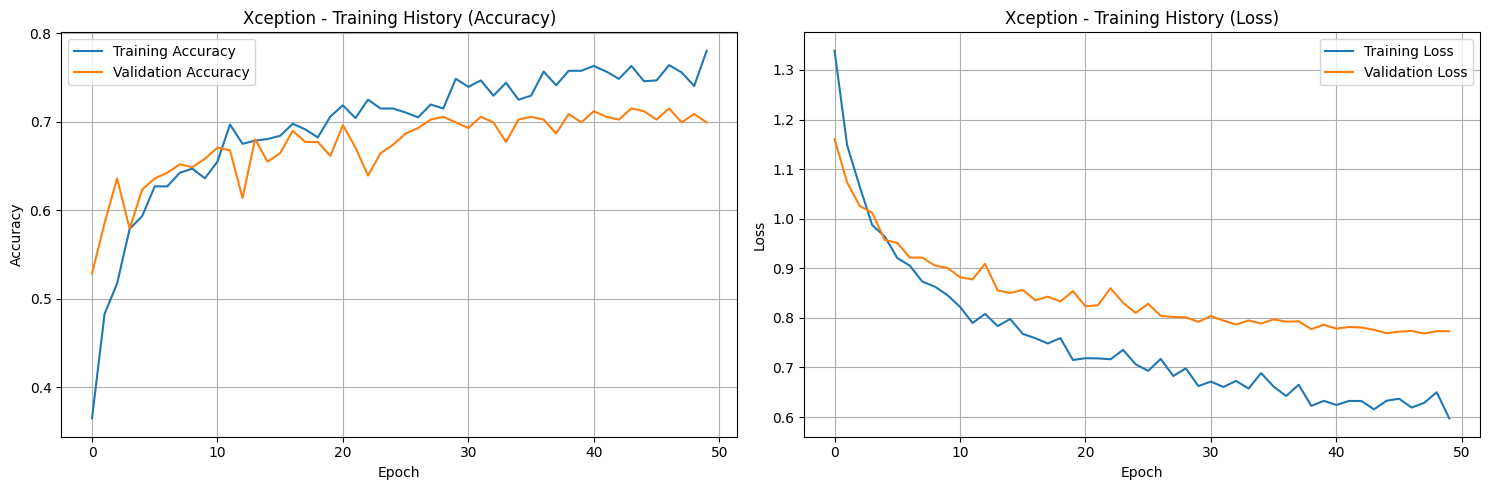

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 314ms/step

=== Xception Evaluation ===
Test Accuracy: 0.7532

Classification Report:
                  precision    recall  f1-score   support

ModerateDemented       0.81      0.92      0.86        38
 NonDemented (2)       0.87      0.82      0.85        40
VeryMildDemented       0.60      0.62      0.61        40
    MildDemented       0.74      0.65      0.69        40

        accuracy                           0.75       158
       macro avg       0.76      0.76      0.75       158
    weighted avg       0.75      0.75      0.75       158



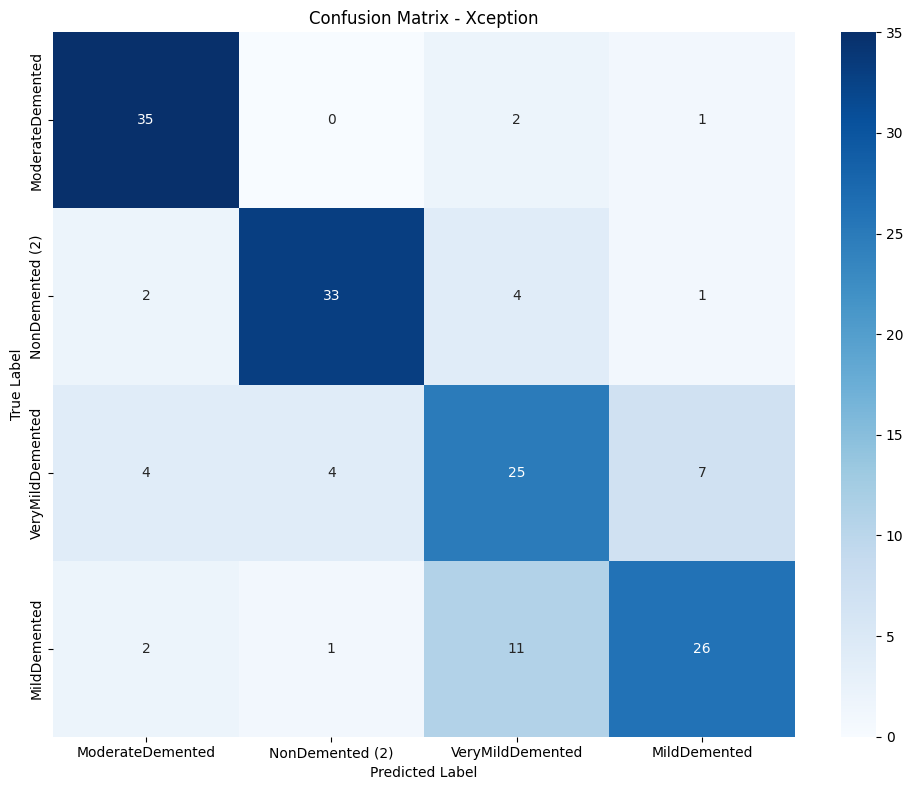

Metrics saved to alzheimer_model_results/Xception_metrics.json

Training NASNetLarge
343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Model architecture created for NASNetLarge
Total parameters: 84,932,950
Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3023 - loss: 1.5187
Epoch 1: val_accuracy improved from -inf to 0.49367, saving model to best_NASNetLarge.h5
69/69 ━━━━━━━━━━━━━━━━━━━━ 105s 774ms/step - accuracy: 0.3028 - loss: 1.5175 - val_accuracy: 0.4937 - val_loss: 1.1901 - learning_rate: 0.0010
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4392 - loss: 1.2190
Epoch 2: val_accuracy improved from 0.49367 to 0.57278, saving model to best_NASNetLarge.h5
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - accuracy: 0.4394 - loss: 1.2188 - val_accuracy: 0.5728 - val_loss: 1.0952 - learning_rate: 0.0010
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5827 - loss: 1.0602
Epoch 3: val_accuracy improved from 0.57278 to 0.58544, saving mod

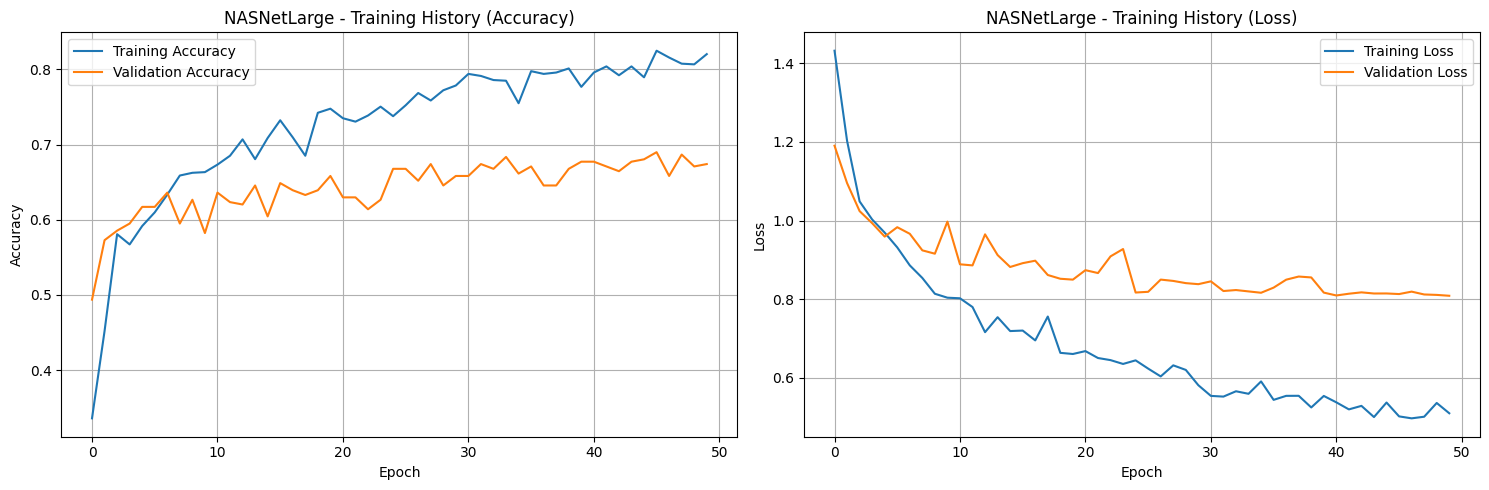

10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step 

=== NASNetLarge Evaluation ===
Test Accuracy: 0.7278

Classification Report:
                  precision    recall  f1-score   support

ModerateDemented       0.85      0.92      0.89        38
 NonDemented (2)       0.70      0.75      0.72        40
VeryMildDemented       0.58      0.53      0.55        40
    MildDemented       0.76      0.72      0.74        40

        accuracy                           0.73       158
       macro avg       0.72      0.73      0.73       158
    weighted avg       0.72      0.73      0.72       158



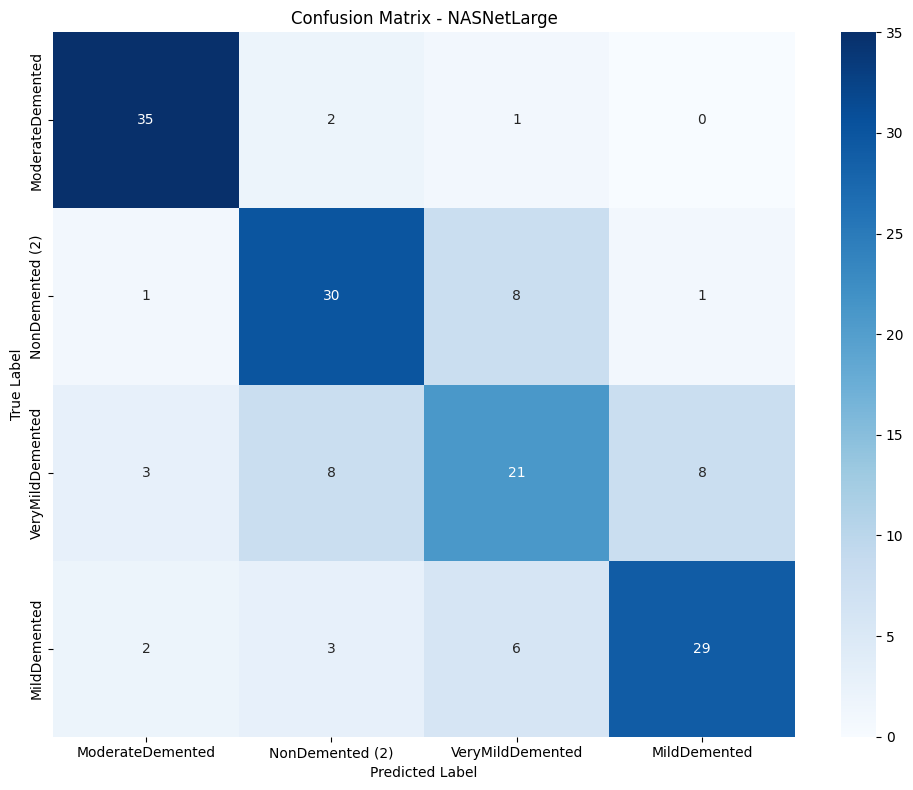

Metrics saved to alzheimer_model_results/NASNetLarge_metrics.json

FINAL RESULTS

=== MODEL COMPARISON ===
Rank  Model Name           Accuracy  
----------------------------------------
1     Xception             0.7532    
2     NASNetLarge          0.7278    


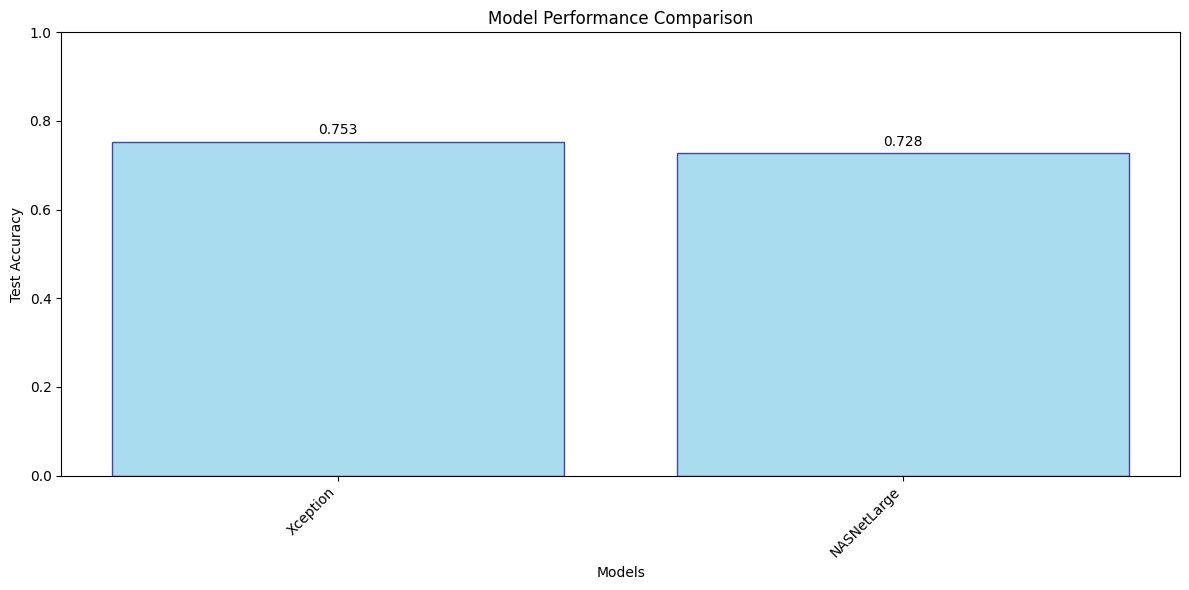

Comparison summary saved to alzheimer_model_results/model_comparison_summary.json

All results saved in 'alzheimer_model_results/' directory
Individual model metrics: [model_name]_metrics.json
Summary comparison: model_comparison_summary.json


In [12]:
if __name__ == "__main__":
    # Set memory growth for GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
    
    # Run main training loop
    results = main()